In [95]:
import os

from autogen_agentchat.agents import AssistantAgent, UserProxyAgent
from autogen_agentchat.conditions import TextMentionTermination
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_core.models import UserMessage
from autogen_ext.models.azure import AzureAIChatCompletionClient
from azure.core.credentials import AzureKeyCredential
from autogen_core import CancellationToken

from autogen_agentchat.messages import TextMessage
from autogen_agentchat.ui import Console
import asyncio

In [ ]:
GITHUB_TOKEN = ""

use GitHub Models for access to the LLM.
https://github.com/marketplace/models

# 3. Building Trustworthy AI Agents

In [21]:
client = AzureAIChatCompletionClient(
    model='Phi-3.5-MoE-instruct',
    endpoint='https://models.inference.ai.azure.com',
    credential=AzureKeyCredential(GITHUB_TOKEN),
    model_info={
        "json_output":True,
        "function_calling": True,
        "vision":False,
        'family': "unknown"
    }
)
# result = await client.create([UserMessage(content="Nước đông Lào là nước nào?", source="user")])
# print(result)

## 3.1 Human-in-the-Loop

In [22]:
agent = AssistantAgent(
    name='assistant',
    model_client=client
)
user_proxy = UserProxyAgent("proxy_user", input_func=input)
termination = TextMentionTermination("APPROVE")
team = RoundRobinGroupChat([agent, user_proxy], termination_condition=termination)

In [ ]:
stream = team.run_stream(task="AI là gì, trả lời 1 cách ngắn gọn?")
await Console(stream) 

---------- user ----------
AI là gì, trả lời 1 cách ngắn gọn?
---------- assistant ----------
 AI, hay Trí tuệ Nhân tạo, là hệ thống máy tính được thiết kế để bắt chước hoạt động trí óc con người, bao gồm học tập, giải quyết vấn đề và ra quyết định. TERMINATE.
---------- proxy_user ----------
học tập thế nào?
---------- assistant ----------
 Học máy, một phần của AI, bao gồm các thuật toán cho phép máy móc học từ dữ liệu và cải thiện theo thời gian mà không cần lập trình trực tiếp. TERMINATE.
---------- proxy_user ----------
APPROVE


TaskResult(messages=[TextMessage(source='user', models_usage=None, content='AI là gì, trả lời 1 cách ngắn gọn?', type='TextMessage'), TextMessage(source='assistant', models_usage=RequestUsage(prompt_tokens=1051, completion_tokens=108), content=' AI, hay Trí tuệ Nhân tạo, là hệ thống máy tính được thiết kế để bắt chước hoạt động trí óc con người, bao gồm học tập, giải quyết vấn đề và ra quyết định. TERMINATE.', type='TextMessage'), UserInputRequestedEvent(source='proxy_user', models_usage=None, request_id='a56db704-2855-4070-9bc2-7aec4da5beb6', content='', type='UserInputRequestedEvent'), TextMessage(source='proxy_user', models_usage=None, content='học tập thế nào?', type='TextMessage'), TextMessage(source='assistant', models_usage=RequestUsage(prompt_tokens=1174, completion_tokens=96), content=' Học máy, một phần của AI, bao gồm các thuật toán cho phép máy móc học từ dữ liệu và cải thiện theo thời gian mà không cần lập trình trực tiếp. TERMINATE.', type='TextMessage'), UserInputRequest

In [19]:
termination = TextMentionTermination("APPROVE")
termination

## 3.2 Meta Prompting System

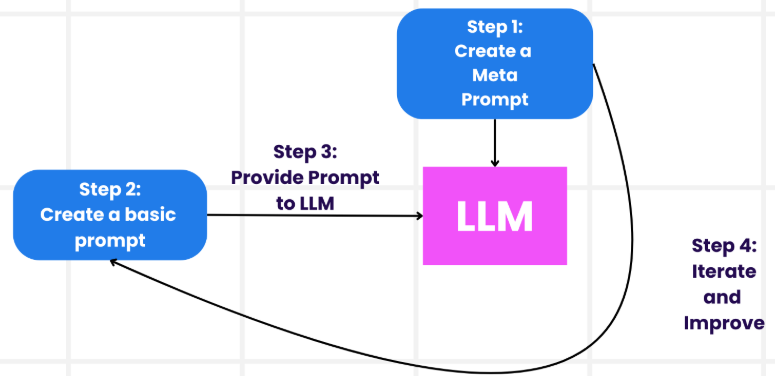

In [23]:
role = "Đại lý du lịch"
company = 'TMA bán vé'
responsibility = 'Bán vé máy bay'

In [24]:
agent = AssistantAgent(
    name='assistant',
    model_client=client,
    system_message="Bạn là một chuyên gia tạo trợ lý AI Agent. Bạn sẽ được cung cấp tên công ty, vai trò, nhiệm vụ và các thông tin khác. Sau đó bạn hãy cung cấp 1 prompt để hệ thống LLM có thể hiểu rõ vai trò, trách nhiệm của trợ lý AI."
)

In [27]:
async def assistant_run():
    response = await agent.on_messages(
        [TextMessage(content=f'Bạn là {role} tại công ty {company} bạn có trách nhiệm {responsibility}', source='user')],
        cancellation_token=CancellationToken()
    )
    print(response.chat_message.content)



In [28]:
await assistant_run()

 **Tên Công ty:** Công ty TMA (TMA Travel & MICE Agency)

**Vai trò:** Đại lý du lịch

**Trách nhiệm:** Bán vé máy bay

**Prompt để hệ thống LLM:** "Giúp Đại lý du lịch tại Công ty TMA trong việc bán vé máy bay bằng cách cung cấp thông tin về chuyến bay, giá vé, giờ bay, điểm đến và quá trình thanh toán, cũng như hỗ trợ khách hàng trong việc lựa chọn chuyến bay, đặt chỗ và xử lý các yêu cầu khác như thay đổi, hủy hoặc hoàn vé."


# 4. Planning Design

In [45]:
from pydantic import BaseModel
from enum import Enum
from typing import List, Optional, Union
import json
import os
from typing import Optional
from pprint import pprint
from autogen_core.models import UserMessage, SystemMessage, AssistantMessage
from autogen_ext.models.azure import AzureAIChatCompletionClient
from azure.core.credentials import AzureKeyCredential


class AgentEnum(str, Enum):
    FlightBooking = "flight_booking"
    HotelBooking = "hotel_booking"
    CarRental = "car_rental"
    ActivitiesBooking = "activities_booking"
    DestinationInfo = "destination_info"
    DefaultAgent = "default_agent"
    GroupChatManager = "group_chat_manager"

# Travel SubTask Model
class TravelSubTask(BaseModel):
    task_details: str
    assigned_agent: AgentEnum  # we want to assign the task to the agent

class TravelPlan(BaseModel):
    main_task: str
    subtasks: List[TravelSubTask]
    is_greeting: bool

In [41]:
# client = AzureAIChatCompletionClient(
#     model="Phi-3.5-MoE-instruct",
#     endpoint="https://models.inference.ai.azure.com",
#     credential=AzureKeyCredential(GITHUB_TOKEN),
#     model_info={
#         "json_output": False,
#         "function_calling": True,
#         "vision": True,
#         "family": "unknown",
#     },
# )

client = AzureAIChatCompletionClient(
    model="gpt-4o-mini",
    endpoint="https://models.inference.ai.azure.com",
    credential=AzureKeyCredential(GITHUB_TOKEN),
    model_info={
        "json_output": False,
        "function_calling": True,
        "vision": True,
        "family": "unknown",
    },
)

In [53]:
# Define the user message
messages = [
    SystemMessage(content="""Bạn là một planner Agent.
    Nhiệm vụ của bạn là chỉ định agents nào để chạy dựa trên yêu cầu của người dùng.
                      Hãy cung cấp dưới dạng JSON theo mẫu sau đây:
{'main_task': 'Lên kế hoạch cho 2 người, chuyến đi từ Huế vào thành phố Hồ Chí Minh.',
 'subtasks': [{'assigned_agent': 'flight_booking',
               'task_details': 'Đặt vé khứ hồi từ Huế vào tp Hồ Chí Minh}]
    Below are the available agents specialised in different tasks:
    - FlightBooking: cho đặt vé máy bay và cung cấp thông tin chuyến bay
    - HotelBooking: cho đặt chỗ khác sạn và cung cấp thông tin khách sạn
    - CarRental: cho đặt xe và và cung cấp thông tin thuê xe
    - ActivitiesBooking: cho đặt chỗ các điểm du lịch và cung cấp thông tin các điểm du lịch
    - DestinationInfo: Cho cung cấp thông tin điểm đến
    - DefaultAgent: Cho xử lý chung của yêu cầu""", source="system"),
    UserMessage(
        content="Lên kế hoạch chi tiết cho chuyến du lịch từ Huế vào thành phố Hồ Chí Minh cho 2 người", source="user"),
]

In [54]:
response = await client.create(messages=messages, extra_create_args={"response_format": 'json_object'})

In [56]:
response_content: Optional[str] = response.content if isinstance(response.content, str) else None
if response_content is None:
    raise ValueError("Response content is not a valid JSON string" )

pprint(json.loads(response_content))

{'main_task': 'Lên kế hoạch chi tiết cho chuyến du lịch từ Huế vào thành phố '
              'Hồ Chí Minh cho 2 người.',
 'subtasks': [{'assigned_agent': 'flight_booking',
               'task_details': 'Đặt vé khứ hồi từ Huế vào tp Hồ Chí Minh cho 2 '
                               'người.'},
              {'assigned_agent': 'hotel_booking',
               'task_details': 'Đặt phòng khách sạn tại tp Hồ Chí Minh cho 2 '
                               'người.'},
              {'assigned_agent': 'car_rental',
               'task_details': 'Đặt xe cho chuyến đi tại tp Hồ Chí Minh.'},
              {'assigned_agent': 'activities_booking',
               'task_details': 'Đặt chỗ cho các hoạt động và điểm du lịch tại '
                               'tp Hồ Chí Minh.'},
              {'assigned_agent': 'destination_info',
               'task_details': 'Cung cấp thông tin về tp Hồ Chí Minh.'}]}


# 5. Multi agent design patterns

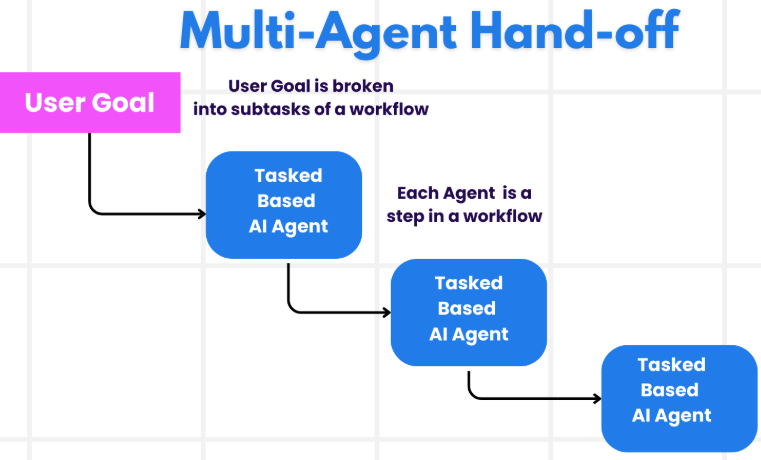

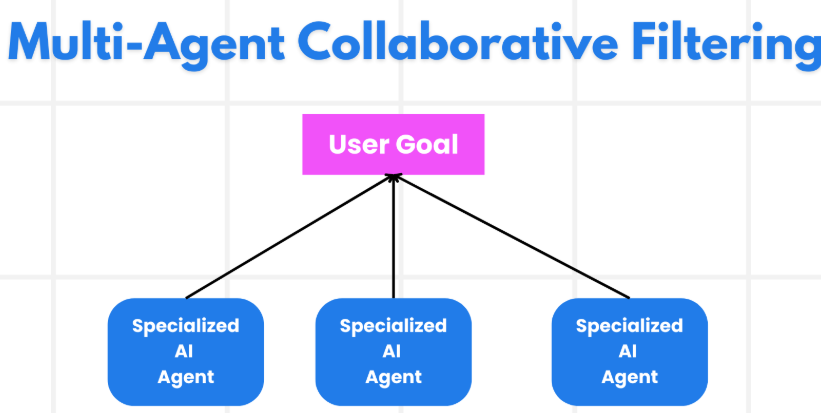

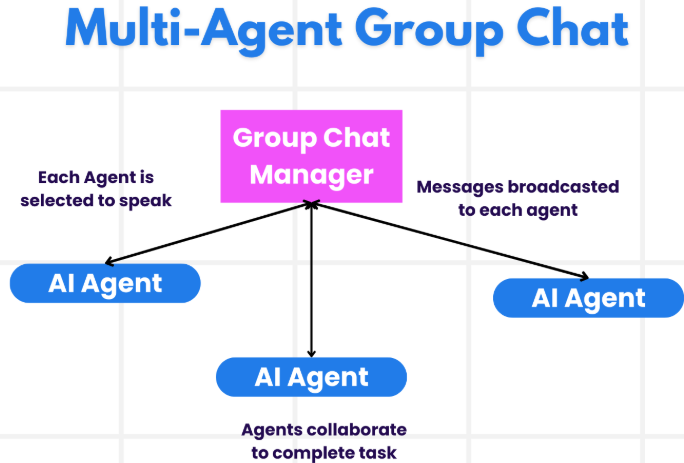

In [58]:
import os
from autogen_agentchat.agents import AssistantAgent
from autogen_core.models import UserMessage
from autogen_ext.models.azure import AzureAIChatCompletionClient
from azure.core.credentials import AzureKeyCredential
from autogen_core import CancellationToken
from autogen_agentchat.base import TaskResult
from autogen_agentchat.messages import TextMessage
from autogen_agentchat.ui import Console
from autogen_agentchat.conditions import TextMentionTermination
from autogen_agentchat.teams import RoundRobinGroupChat

In [60]:
client = AzureAIChatCompletionClient(
    model="gpt-4o-mini",
    endpoint="https://models.inference.ai.azure.com",
    credential=AzureKeyCredential(GITHUB_TOKEN),
    model_info={
        "json_output": True,
        "function_calling": True,
        "vision": True,
        "family": "unknown",
    },
)

In [63]:
frontdesk_agent = AssistantAgent(
    name='planner_Agent',
    model_client=client,
    description="Một trợ lý hữu ích có thể lên kế hoạch cho chuyến đi.",
    system_message="""Bạn là lễ tân của 1 đại lý du lịch với 10 năm kinh nghiệm và trả lời ngắn gọn kể cả khi thoả thuận với nhiều khách hàng.
                        Mục tiêu của bạn là cung cấp hoạt động và địa điểm du lịch tốt nhất cho khách hàng thăm quan.
                        Chỉ cung cấp 1 gợi ý cho 1 khách hàng.
                        Bạn chỉ tập trung làm việc vào mục tiêu của mình.
                        Đừng tốn thời gian bằng tin nhắn chit chat.
                        Xem xét các đề xuất khi đưa ra 1 ý tưởng."""
)

concierge_agent = AssistantAgent(
    "concierge_agent",
    model_client=client,
    description="Một trợ lý địa phương có thể gợi ý các địa điểm, hoạt động ở địa phương để du khách thăm quan.",
    system_message="""
    Bạn là một người hướng dẫn viên có nhiều chuyên môn trong việc cung cấp trải nghiệm địa phương và chân thực nhất cho khách du lịch.
    Mục tiêu được thực hiện, nếu lễ tân đại lý yêu cầu một trải nghiệm du lịch địa phương cho khách thăm quan.
    Nếu đúng, hãy phản hồi bằng 'APPROVE'.
    Nếu không, hãy đưa ra gợi ý để cải thiện đề xuất mà không sử dụng một ví dụ cụ thể. 
    """,
)

In [64]:
termination = TextMentionTermination("APPROVE")
team = RoundRobinGroupChat([frontdesk_agent, concierge_agent], termination_condition=termination)

In [ ]:
async for message in team.run_stream(task="Tôi muốn lên kế hoạch du lịch Huế."):
    if isinstance(message, TaskResult):
        print("Stop Reason:", message.stop_reason)
    else:
        print(message)

source='user' models_usage=None content='Tôi muốn lên kế hoạch du lịch Huế.' type='TextMessage'
source='planner_Agent' models_usage=RequestUsage(prompt_tokens=141, completion_tokens=39) content='Tôi gợi ý bạn nên tham quan Cố đô Huế, nơi có nhiều di sản văn hóa và lịch sử, như Đại Nội và các lăng tẩm của vua Nguyễn.' type='TextMessage'
source='concierge_agent' models_usage=RequestUsage(prompt_tokens=164, completion_tokens=85) content='Gợi ý của bạn về việc tham quan Cố đô Huế và các di sản văn hóa, lịch sử là rất tốt. Tuy nhiên, để cải thiện đề xuất, bạn có thể thêm vào các trải nghiệm văn hóa địa phương như tham gia vào các hoạt động nghệ thuật truyền thống, thưởng thức ẩm thực đặc sản địa phương, hoặc tìm hiểu về phong tục tập quán của người dân nơi đây.' type='TextMessage'
source='planner_Agent' models_usage=RequestUsage(prompt_tokens=273, completion_tokens=56) content='Tôi gợi ý bạn tham gia vào một tour đêm tại phố cổ Huế, nơi bạn có thể thưởng thức ẩm thực đặc sản như bún bò Huế,

# 6. Metacognition AI Agents

## 6.1 Planning in Agents | Corrective RAG System

In [66]:
import random

def search_flights(preferences):
    destination = preferences.get("destination", "Unknown")
    return [
        {"flight": f"Flight-{random.randint(100, 999)}", "price": random.randint(200, 1000), "destination": destination}
    ]

def search_hotels(preferences):
    destination = preferences.get("destination", "Unknown")
    return [
        {"hotel": f"Hotel-{random.randint(1, 50)}", "rating": random.uniform(3, 5), "destination": destination}
    ]

def search_attractions(preferences):
    interests = preferences.get("interests", [])
    return [
        {"attraction": f"{interest} Experience", "rating": random.uniform(3, 5)} for interest in interests
    ]

def create_itinerary(flights, hotels, attractions):
    return {
        "flight": flights[0] if flights else None,
        "hotel": hotels[0] if hotels else None,
        "attractions": attractions
    }

def adjust_preferences(preferences, feedback):
    if "disliked" in feedback:
        preferences["interests"] = [i for i in preferences.get("interests", []) if i not in feedback["disliked"]]
    return preferences

In [67]:
class Travel_Agent:
    def __init__(self):
        self.user_preferences = {}
        self.experience_data = []
    
    def gather_preferences(self, preferences):
        self.user_preferences = preferences
    
    def retrieve_information(self):
        flights = search_flights(self.user_preferences)
        hotels = search_hotels(self.user_preferences)
        attractions = search_attractions(self.user_preferences)
        return flights, hotels, attractions
    
    def generate_recommendations(self):
        flights, hotels, attractions = self.retrieve_information()
        itinerary = create_itinerary(flights, hotels, attractions)
        return itinerary
    
    def adjust_based_on_feedback(self, feedback):
        self.experience_data.append(feedback)
        # Analyze feedback and adjust future recommendations
        self.user_preferences = adjust_preferences(self.user_preferences, feedback)



In [78]:
# Example usage
travel_agent = Travel_Agent()
preferences = {
    "destination": "Paris",
    "dates": "2025-04-01 to 2025-04-10",
    "budget": "moderate",
    "interests": ["museums", "cuisine", "Eiffel Tower"]
}
travel_agent.gather_preferences(preferences)

In [79]:
travel_agent.user_preferences

{'destination': 'Paris',
 'dates': '2025-04-01 to 2025-04-10',
 'budget': 'moderate',
 'interests': ['museums', 'cuisine', 'Eiffel Tower']}

In [80]:
itinerary = travel_agent.generate_recommendations()
print("Suggested Itinerary:", itinerary)

Suggested Itinerary: {'flight': {'flight': 'Flight-929', 'price': 654, 'destination': 'Paris'}, 'hotel': {'hotel': 'Hotel-19', 'rating': 4.573210793126879, 'destination': 'Paris'}, 'attractions': [{'attraction': 'museums Experience', 'rating': 3.711872824841949}, {'attraction': 'cuisine Experience', 'rating': 4.049767598496947}, {'attraction': 'Eiffel Tower Experience', 'rating': 4.57766416023432}]}


In [81]:
feedback = {"liked": ["Louvre Museum"], "disliked": ["Eiffel Tower"]}
travel_agent.adjust_based_on_feedback(feedback)

In [84]:
itinerary = travel_agent.generate_recommendations()
print("Update Itinerary Itinerary:", itinerary)

Update Itinerary Itinerary: {'flight': {'flight': 'Flight-121', 'price': 812, 'destination': 'Paris'}, 'hotel': {'hotel': 'Hotel-15', 'rating': 3.0793702324911685, 'destination': 'Paris'}, 'attractions': [{'attraction': 'museums Experience', 'rating': 3.236302390846093}, {'attraction': 'cuisine Experience', 'rating': 3.6255069621706864}]}


In [82]:
travel_agent.user_preferences

{'destination': 'Paris',
 'dates': '2025-04-01 to 2025-04-10',
 'budget': 'moderate',
 'interests': ['museums', 'cuisine']}

## 6.2 Pre-emptive Context Load

In [85]:
class TravelAgent:
    def __init__(self):
        # Pre-load popular destinations and their information
        self.context = {
            "Paris": {"country": "France", "currency": "Euro", "language": "French", "attractions": ["Eiffel Tower", "Louvre Museum"]},
            "Tokyo": {"country": "Japan", "currency": "Yen", "language": "Japanese", "attractions": ["Tokyo Tower", "Shibuya Crossing"]},
            "New York": {"country": "USA", "currency": "Dollar", "language": "English", "attractions": ["Statue of Liberty", "Times Square"]},
            "Sydney": {"country": "Australia", "currency": "Dollar", "language": "English", "attractions": ["Sydney Opera House", "Bondi Beach"]}
        }

    def get_destination_info(self, destination):
        # Fetch destination information from pre-loaded context
        info = self.context.get(destination)
        if info:
            return f"{destination}:\nCountry: {info['country']}\nCurrency: {info['currency']}\nLanguage: {info['language']}\nAttractions: {', '.join(info['attractions'])}"
        else:
            return f"Sorry, we don't have information on {destination}."

# Example usage
travel_agent = TravelAgent()
print(travel_agent.get_destination_info("Paris"))
print(travel_agent.get_destination_info("Tokyo"))

Paris:
Country: France
Currency: Euro
Language: French
Attractions: Eiffel Tower, Louvre Museum
Tokyo:
Country: Japan
Currency: Yen
Language: Japanese
Attractions: Tokyo Tower, Shibuya Crossing


## 6.3 Bootstrapping the Plan with a Goal Before Iterating

In [93]:
class TravelAgent:
    def __init__(self, destinations):
        self.destinations = destinations

    def bootstrap_plan(self, preferences, budget):
        plan = []
        total_cost = 0

        for destination in self.destinations:
            if total_cost + destination['cost'] <= budget and self.match_preferences(destination, preferences):
                plan.append(destination)
                total_cost += destination['cost']

        return plan

    def match_preferences(self, destination, preferences):
        for key, value in preferences.items():
            if destination.get(key) != value:
                return False
        return True

    def iterate_plan(self, plan, preferences, budget):
        for i in range(len(plan)):
            for destination in self.destinations:
                if destination not in plan and self.match_preferences(destination, preferences) and self.calculate_cost(plan, destination) <= budget:
                    plan[i] = destination
                    break
        return plan

    def calculate_cost(self, plan, new_destination):
        return sum(destination['cost'] for destination in plan) + new_destination['cost']

# Example usage
destinations = [
    {"name": "Paris", "cost": 1000, "activity": "sightseeing"},
    {"name": "Tokyo", "cost": 1200, "activity": "shopping"},
    {"name": "New York", "cost": 900, "activity": "sightseeing"},
    {"name": "Sydney", "cost": 1100, "activity": "beach"},
    {"name": "Laos", "cost": 800, "activity": "sightseeing"},
]

preferences = {"activity": "sightseeing"}
budget = 2000

travel_agent = TravelAgent(destinations)
initial_plan = travel_agent.bootstrap_plan(preferences, budget)
print("Initial Plan:", initial_plan)

Initial Plan: [{'name': 'Paris', 'cost': 1000, 'activity': 'sightseeing'}, {'name': 'New York', 'cost': 900, 'activity': 'sightseeing'}]


In [94]:
refined_plan = travel_agent.iterate_plan(initial_plan, preferences, budget)
print("Refined Plan:", refined_plan)

Refined Plan: [{'name': 'Paris', 'cost': 1000, 'activity': 'sightseeing'}, {'name': 'New York', 'cost': 900, 'activity': 'sightseeing'}]


## 6.4 Taking Advantage of LLM for Re-ranking and Scoring

In [120]:
client = AzureAIChatCompletionClient(
    model="gpt-4o-mini",
    endpoint="https://models.inference.ai.azure.com",
    credential=AzureKeyCredential(GITHUB_TOKEN),
    model_info={
        "json_output": True,
        "function_calling": True,
        "vision": False,
        "family": "unknown",
    },
)
# result = await client.create([UserMessage(content="Thủ đô của Việt Nam là gì?", source="user")])
# print(result)

In [121]:
import requests
import json

class TravelAgent:
    def __init__(self, destinations):
        self.destinations = destinations

    async def get_recommendations(self, preferences, client):
        # Generate a prompt for the Azure OpenAI
        prompt = self.generate_prompt(preferences)
        print(prompt)
        # Call the Azure OpenAI API to get the re-ranked and scored destinations
        response = await client.create([UserMessage(content=prompt, source="user")])
        results = response.content.split('\n')
        return results

    def generate_prompt(self, preferences):
        prompt = "Here are the travel destinations ranked and scored based on the following user preferences:\n"
        for key, value in preferences.items():
            prompt += f"{key}: {value}\n"
        prompt += "\nDestinations:\n"
        for destination in self.destinations:
            prompt += f"- {destination['name']}: {destination['description']}\n"
        return prompt

In [ ]:
# Example usage
destinations = [
    {"name": "Paris", "description": "City of lights, known for its art, fashion, and culture."},
    {"name": "Tokyo", "description": "Vibrant city, famous for its modernity and traditional temples."},
    {"name": "New York", "description": "The city that never sleeps, with iconic landmarks and diverse culture."},
    {"name": "Sydney", "description": "Beautiful harbour city, known for its opera house and stunning beaches."},
]
preferences = {"activity": "sightseeing", "culture": "diverse"}

travel_agent = TravelAgent(destinations)
recommendations = await travel_agent.get_recommendations(preferences, client)
print("Recommended Destinations: ", recommendations)
for rec in recommendations:
    print(rec)

Here are the travel destinations ranked and scored based on the following user preferences:
activity: sightseeing
culture: diverse

Destinations:
- Paris: City of lights, known for its art, fashion, and culture.
- Tokyo: Vibrant city, famous for its modernity and traditional temples.
- New York: The city that never sleeps, with iconic landmarks and diverse culture.
- Sydney: Beautiful harbour city, known for its opera house and stunning beaches.

Recommended Destinations:  ['Based on the user preferences for sightseeing and diverse culture, here are the ranked travel destinations along with a scoring rationale:', '', '1. **New York**  ', '   **Score: 9/10**  ', '   - **Sightseeing:** Home to iconic landmarks like the Statue of Liberty, Times Square, Central Park, and the Empire State Building.', '   - **Culture:** Extremely diverse, with a melting pot of cultures represented through its neighborhoods, food, festivals, and arts.', '', '2. **Tokyo**  ', '   **Score: 8.5/10**  ', '   - **

## Example

In [ ]:
class HotelRecommendationAgent:
    def __init__(self):
        self.previous_choices = []  # Stores the hotels chosen previously
        self.corrected_choices = []  # Stores the corrected choices
        self.recommendation_strategies = ['cheapest', 'highest_quality']  # Available strategies

    def recommend_hotel(self, hotels, strategy):
        """
        Recommend a hotel based on the chosen strategy.
        The strategy can either be 'cheapest' or 'highest_quality'.
        """
        if strategy == 'cheapest':
            recommended = min(hotels, key=lambda x: x['price'])
        elif strategy == 'highest_quality':
            recommended = max(hotels, key=lambda x: x['quality'])
        else:
            recommended = None
        self.previous_choices.append((strategy, recommended))
        return recommended
    
    def get_user_feedback(self, hotel):
        """
        Simulate user feedback based on hotel attributes.
        For simplicity, assume if the hotel is too cheap, the feedback is "bad".
        If the hotel has quality less than 7, feedback is "bad".
        """
        if hotel['price'] < 100 or hotel['quality'] < 7:
            return "bad"
        return "good"
    
    def reflect_on_choice(self):
        """
        Reflect on the last choice made and decide if the agent should adjust its strategy.
        The agent considers if the previous choice led to a poor outcome.
        """
        if not self.previous_choices:
            return "No choices made yet."

        last_choice_strategy, last_choice = self.previous_choices[-1]
        # Let's assume we have some user feedback that tells us whether the last choice was good or not
        user_feedback = self.get_user_feedback(last_choice)

        if user_feedback == "bad":
            # Adjust strategy if the previous choice was unsatisfactory
            new_strategy = 'highest_quality' if last_choice_strategy == 'cheapest' else 'cheapest'
            self.corrected_choices.append((new_strategy, last_choice))
            return f"Reflecting on choice. Adjusting strategy to {new_strategy}."
        else:
            return "The choice was good. No need to adjust."


In [140]:
# Simulate a list of hotels (price and quality)
hotels = [
    {'name': 'Budget Inn', 'price': 80, 'quality': 6},
    {'name': 'Comfort Suites', 'price': 120, 'quality': 8},
    {'name': 'Luxury Stay', 'price': 200, 'quality': 9}
]

# Create an agent
agent = HotelRecommendationAgent()

In [141]:
# Step 1: The agent recommends a hotel using the "cheapest" strategy
recommended_hotel = agent.recommend_hotel(hotels, 'cheapest')
print(f"Recommended hotel (cheapest): {recommended_hotel['name']}")

Recommended hotel (cheapest): Budget Inn


In [142]:
agent.previous_choices

[('cheapest', {'name': 'Budget Inn', 'price': 80, 'quality': 6})]

In [143]:
# Step 2: The agent reflects on the choice and adjusts strategy if necessary
reflection_result = agent.reflect_on_choice()
print(reflection_result)

Reflecting on choice. Adjusting strategy to highest_quality.


In [144]:
print(agent.previous_choices)
print(agent.corrected_choices)

[('cheapest', {'name': 'Budget Inn', 'price': 80, 'quality': 6})]
[('highest_quality', {'name': 'Budget Inn', 'price': 80, 'quality': 6})]


In [145]:
# Step 3: The agent recommends again, this time using the adjusted strategy
adjusted_recommendation = agent.recommend_hotel(hotels, 'highest_quality')
print(f"Adjusted hotel recommendation (highest_quality): {adjusted_recommendation['name']}")

Adjusted hotel recommendation (highest_quality): Luxury Stay
